# Cox–Ross–Rubinstein (CRR) Binomial Model – Pricing & Trading Demo

This notebook illustrates:

1. **CRR binomial pricing**
   - European call/put pricing on a recombining tree
   - Convergence of CRR prices to Black–Scholes as the number of steps `N` increases

2. **American vs European options**
   - American call vs European call (on non-dividend stock)
   - American put vs European put

3. **A toy trading strategy based on CRR mispricing**
   - "Market" uses a coarse, low-step CRR tree to price calls
   - Our model uses a finer, high-step CRR tree as fair value
   - We construct a cross-sectional strategy across strikes and
     simulate the PnL distribution under the high-step CRR model


In [3]:
import warnings
warnings.filterwarnings("ignore")  
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from math import exp, sqrt, log
from typing import Literal

In [5]:
def norm_cdf(x):
    """Standard normal CDF using error function."""
    from math import erf
    x = np.asarray(x, dtype=float)
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))


def bs_call_price(S0, K, T, r, sigma):
    """
    Black–Scholes European call price.
    """
    if T <= 0.0 or sigma <= 0.0:
        return max(S0 - K, 0.0)

    d1 = (log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    return float(S0 * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2))


def bs_put_price(S0, K, T, r, sigma):
    """
    Black–Scholes European put price.
    """
    if T <= 0.0 or sigma <= 0.0:
        return max(K - S0, 0.0)

    d1 = (log(S0 / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    return float(K * exp(-r * T) * norm_cdf(-d2) - S0 * norm_cdf(-d1))


In [7]:
OptionType = Literal["call", "put"]


@dataclass
class CRRParams:
    """
    Parameters for Cox–Ross–Rubinstein (CRR) binomial option pricing.

    We use the standard CRR parameterisation:

        dt = T / N
        u  = exp(sigma * sqrt(dt))
        d  = 1 / u
        p  = (exp(r * dt) - d) / (u - d)

    Attributes
    ----------
    S0 : float
        Spot price at time 0.
    K : float
        Strike price.
    T : float
        Time to maturity in years.
    r : float
        Risk-free rate (continuous compounding).
    sigma : float
        Volatility of the underlying.
    N : int
        Number of time steps in the binomial tree (N >= 1).
    option_type : {"call", "put"}
        Payoff type. Defaults to "call".
    """

    S0: float
    K: float
    T: float
    r: float
    sigma: float
    N: int
    option_type: OptionType = "call"

    def __post_init__(self):
        if self.N <= 0:
            raise ValueError("N (number of steps) must be positive.")
        if self.T <= 0.0:
            raise ValueError("T (maturity) must be positive.")
        if self.sigma <= 0.0:
            raise ValueError("sigma (volatility) must be positive.")
        if self.option_type not in ("call", "put"):
            raise ValueError("option_type must be 'call' or 'put'.")


def _crr_ud_p(r: float, sigma: float, T: float, N: int):
    """
    Compute (dt, u, d, p) for the standard CRR binomial tree.
    """
    dt = T / N
    u = exp(sigma * sqrt(dt))
    d = 1.0 / u
    disc = exp(r * dt)
    denom = u - d
    if denom == 0.0:
        raise ValueError("u and d coincide; invalid CRR parameters.")
    p = (disc - d) / denom
    if not (0.0 <= p <= 1.0):
        raise ValueError(f"Risk-neutral probability out of [0,1]: p={p:.4f}")
    return dt, u, d, p


def _payoff(spot: float, K: float, option_type: OptionType) -> float:
    if option_type == "call":
        return max(spot - K, 0.0)
    else:
        return max(K - spot, 0.0)


def crr_price_european(params: CRRParams) -> float:
    """
    Price a European call or put using the CRR binomial model.
    """
    dt, u, d, p = _crr_ud_p(params.r, params.sigma, params.T, params.N)
    disc = exp(-params.r * dt)

    # Terminal payoffs at maturity
    values = [
        _payoff(
            spot=params.S0 * (u ** j) * (d ** (params.N - j)),
            K=params.K,
            option_type=params.option_type,
        )
        for j in range(params.N + 1)
    ]

    # Backward induction (no early exercise)
    for n in range(params.N - 1, -1, -1):
        values = [
            disc * (p * values[j + 1] + (1.0 - p) * values[j])
            for j in range(n + 1)
        ]

    return float(values[0])


def crr_price_american(params: CRRParams) -> float:
    """
    Price an American call or put using the CRR binomial model.
    """
    dt, u, d, p = _crr_ud_p(params.r, params.sigma, params.T, params.N)
    disc = exp(-params.r * dt)

    # Stock prices at maturity
    spots = [
        params.S0 * (u ** j) * (d ** (params.N - j))
        for j in range(params.N + 1)
    ]
    values = [
        _payoff(spot=s, K=params.K, option_type=params.option_type)
        for s in spots
    ]

    # Backward induction with early exercise
    for n in range(params.N - 1, -1, -1):
        new_values = []
        new_spots = []
        for j in range(n + 1):
            s_ij = params.S0 * (u ** j) * (d ** (n - j))
            continuation = disc * (p * values[j + 1] + (1.0 - p) * values[j])
            exercise = _payoff(spot=s_ij, K=params.K, option_type=params.option_type)
            new_values.append(max(continuation, exercise))
            new_spots.append(s_ij)
        values = new_values
        spots = new_spots

    return float(values[0])


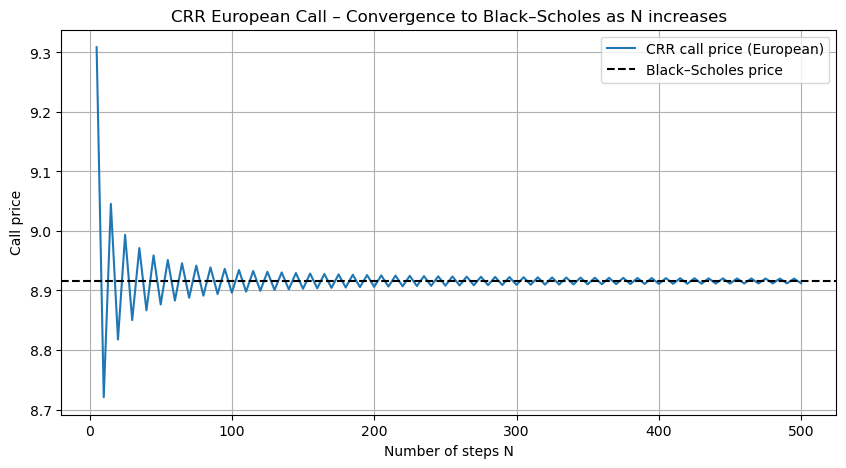

Black–Scholes call price: 8.9160
CRR call price at N=20  : 8.8176
CRR call price at N=500 : 8.9121


In [9]:
def plot_crr_convergence_to_bs():
    """
    Plot CRR European call price as a function of N,
    and show convergence to the Black–Scholes price.
    """
    S0 = 100.0
    K = 100.0
    T = 1.0
    r = 0.02
    sigma = 0.2

    bs = bs_call_price(S0, K, T, r, sigma)

    N_values = np.arange(5, 501, 5)
    crr_prices = []

    for N in N_values:
        params = CRRParams(
            S0=S0,
            K=K,
            T=T,
            r=r,
            sigma=sigma,
            N=int(N),
            option_type="call",
        )
        crr_prices.append(crr_price_european(params))

    crr_prices = np.asarray(crr_prices)

    plt.figure(figsize=(10, 5))
    plt.plot(N_values, crr_prices, label="CRR call price (European)")
    plt.axhline(bs, color="black", linestyle="--", label="Black–Scholes price")
    plt.xlabel("Number of steps N")
    plt.ylabel("Call price")
    plt.title("CRR European Call – Convergence to Black–Scholes as N increases")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Black–Scholes call price: {bs:.4f}")
    print(f"CRR call price at N=20  : {crr_prices[N_values.tolist().index(20)]:.4f}")
    print(f"CRR call price at N=500 : {crr_prices[-1]:.4f}")


plot_crr_convergence_to_bs()


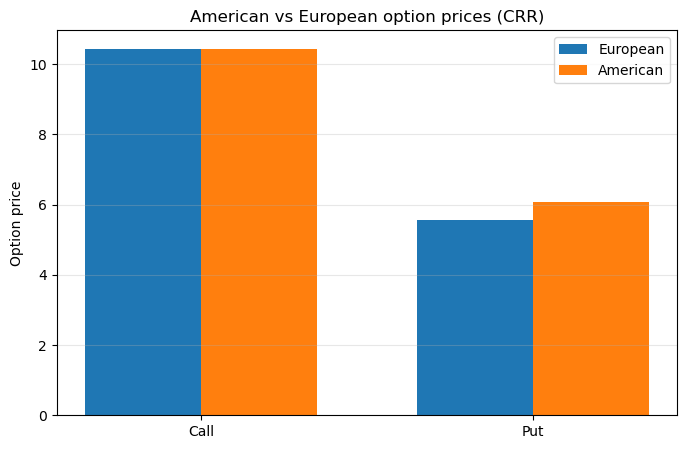

=== Prices ===
European call : 10.4466
American call : 10.4466

European put  : 5.5695
American put  : 6.0888


In [11]:
def compare_american_vs_european():
    """
    Compare American vs European prices for call and put.
    """
    S0 = 100.0
    K = 100.0
    T = 1.0
    r = 0.05
    sigma = 0.2
    N = 500

    # Call
    params_call = CRRParams(S0=S0, K=K, T=T, r=r, sigma=sigma, N=N, option_type="call")
    eur_call = crr_price_european(params_call)
    amer_call = crr_price_american(params_call)

    # Put (more interesting for early exercise)
    params_put = CRRParams(S0=S0, K=K, T=T, r=r, sigma=sigma, N=N, option_type="put")
    eur_put = crr_price_european(params_put)
    amer_put = crr_price_american(params_put)

    labels = ["Call", "Put"]
    eur_prices = [eur_call, eur_put]
    amer_prices = [amer_call, amer_put]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width / 2, eur_prices, width, label="European")
    plt.bar(x + width / 2, amer_prices, width, label="American")
    plt.xticks(x, labels)
    plt.ylabel("Option price")
    plt.title("American vs European option prices (CRR)")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.show()

    print("=== Prices ===")
    print(f"European call : {eur_call:.4f}")
    print(f"American call : {amer_call:.4f}")
    print()
    print(f"European put  : {eur_put:.4f}")
    print(f"American put  : {amer_put:.4f}")


compare_american_vs_european()


In [13]:
def crr_terminal_prices(S0, r, sigma, T, N, n_paths=20000, seed=123):
    """
    Simulate terminal prices S_T under the CRR model with N steps
    using the risk-neutral probability p.

    This is equivalent to sampling the binomial distribution of up-moves.
    """
    rng = np.random.default_rng(seed)
    dt, u, d, p = _crr_ud_p(r, sigma, T, N)

    # Number of up-moves ~ Binomial(N, p)
    ups = rng.binomial(N, p, size=n_paths)
    downs = N - ups
    ST = S0 * (u ** ups) * (d ** downs)
    return ST


def run_crr_mispricing_strategy(
    S0=100.0,
    T=1.0,
    r=0.02,
    sigma=0.2,
    N_market=20,
    N_model=500,
    K_min=80.0,
    K_max=120.0,
    n_strikes=11,
    mispricing_threshold=0.03,
    n_paths=50000,
    seed=123,
):
    """
    Toy CRR-based cross-sectional trading strategy.

    - "Market" prices calls with a coarse CRR tree (N_market steps).
    - Our model uses a fine CRR tree (N_model steps) as fair value.
    - For each strike:
        if (model_price - market_price) / market_price >  threshold -> buy call
        if (model_price - market_price) / market_price < -threshold -> short call
        otherwise -> no trade
    - We simulate terminal prices under the high-step CRR (N_model) and
      compute PnL of this static options book at maturity.
    """
    Ks = np.linspace(K_min, K_max, n_strikes)

    market_prices = []
    model_prices = []

    for K in Ks:
        params_market = CRRParams(S0=S0, K=K, T=T, r=r, sigma=sigma, N=N_market, option_type="call")
        params_model = CRRParams(S0=S0, K=K, T=T, r=r, sigma=sigma, N=N_model, option_type="call")
        market_prices.append(crr_price_european(params_market))
        model_prices.append(crr_price_european(params_model))

    market_prices = np.asarray(market_prices)
    model_prices = np.asarray(model_prices)

    rel_mispricing = (model_prices - market_prices) / market_prices

    trade_sides = np.zeros_like(Ks, dtype=int)
    trade_sides[rel_mispricing > mispricing_threshold] = 1    # buy call
    trade_sides[rel_mispricing < -mispricing_threshold] = -1   # short call

    # Simulate terminal prices under high-step CRR
    ST = crr_terminal_prices(S0, r, sigma, T, N_model, n_paths=n_paths, seed=seed)

    # Compute PnL per path
    payoffs = np.maximum(ST[:, None] - Ks[None, :], 0.0)
    pnl_matrix = trade_sides[None, :] * (payoffs - market_prices[None, :])
    pnl_total = pnl_matrix.sum(axis=1)

    results = {
        "S0": S0,
        "T": T,
        "r": r,
        "sigma": sigma,
        "N_market": N_market,
        "N_model": N_model,
        "Ks": Ks,
        "market_prices": market_prices,
        "model_prices": model_prices,
        "rel_mispricing": rel_mispricing,
        "trade_sides": trade_sides,
        "ST": ST,
        "pnl_matrix": pnl_matrix,
        "pnl_total": pnl_total,
    }

    return results


In [19]:
def plot_crr_mispricing(results):
    Ks = results["Ks"]
    market_prices = results["market_prices"]
    model_prices = results["model_prices"]
    rel_mispricing = results["rel_mispricing"]
    trade_sides = results["trade_sides"]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(Ks, market_prices, label="Market CRR (N_market)", marker="o")
    ax1.plot(Ks, model_prices, label="Model CRR (N_model)", marker="x")
    ax1.set_xlabel("Strike K")
    ax1.set_ylabel("Call price")
    ax1.grid(True)
    ax1.legend(loc="upper right")

    ax2 = ax1.twinx()
    ax2.plot(Ks, rel_mispricing, color="tab:red", linestyle="--", label="Rel. mispricing")
    ax2.axhline(0.0, color="tab:red", linewidth=1)
    ax2.set_ylabel("Relative mispricing (model - market) / market")

    # Mark trades
    for K, side in zip(Ks, trade_sides):
        if side == 1:
            ax1.scatter(K, market_prices[list(Ks).index(K)], marker="^", s=80, color="green", label="Buy call")
        elif side == -1:
            ax1.scatter(K, market_prices[list(Ks).index(K)], marker="v", s=80, color="red", label="Short call")

    # Avoid duplicate legend entries for trade markers
    handles, labels = ax1.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax1.legend(unique.values(), unique.keys(), loc="upper right")

    plt.title("CRR Mispricing: Market (coarse N) vs Model (fine N)")
    plt.show()

    print("Strikes and trade sides:")
    for K, side, mis in zip(Ks, trade_sides, rel_mispricing):
        action = "NO TRADE"
        if side == 1:
            action = "BUY call"
        elif side == -1:
            action = "SHORT call"
        print(f"K={K:6.2f}, rel_mispricing={mis:+.3%}, action={action}")


def plot_crr_pnl_distribution(results):
    pnl = results["pnl_total"]

    plt.figure(figsize=(10, 5))
    plt.hist(pnl, bins=50, density=True)
    plt.axvline(0.0, color="black", linestyle="--", linewidth=1)
    plt.title("CRR Mispricing Strategy – PnL Distribution")
    plt.xlabel("Total PnL over all strikes (per path)")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

    mean_pnl = pnl.mean()
    std_pnl = pnl.std()
    p5 = np.percentile(pnl, 5)
    p50 = np.percentile(pnl, 50)
    p95 = np.percentile(pnl, 95)

    print("=== PnL summary ===")
    print(f"Mean PnL    : {mean_pnl:.4f}")
    print(f"Std PnL     : {std_pnl:.4f}")
    print(f"5% quantile : {p5:.4f}")
    print(f"Median      : {p50:.4f}")
    print(f"95% quantile: {p95:.4f}")


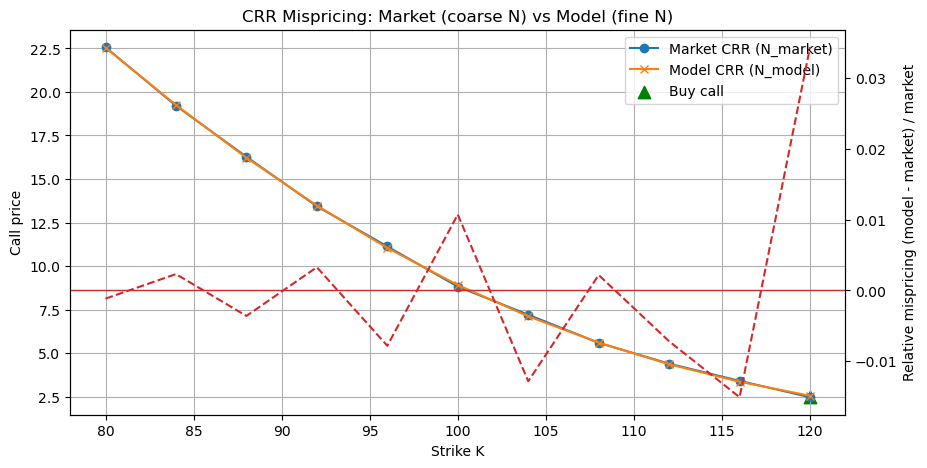

Strikes and trade sides:
K= 80.00, rel_mispricing=-0.116%, action=NO TRADE
K= 84.00, rel_mispricing=+0.230%, action=NO TRADE
K= 88.00, rel_mispricing=-0.360%, action=NO TRADE
K= 92.00, rel_mispricing=+0.327%, action=NO TRADE
K= 96.00, rel_mispricing=-0.781%, action=NO TRADE
K=100.00, rel_mispricing=+1.071%, action=NO TRADE
K=104.00, rel_mispricing=-1.281%, action=NO TRADE
K=108.00, rel_mispricing=+0.217%, action=NO TRADE
K=112.00, rel_mispricing=-0.718%, action=NO TRADE
K=116.00, rel_mispricing=-1.506%, action=NO TRADE
K=120.00, rel_mispricing=+3.430%, action=BUY call


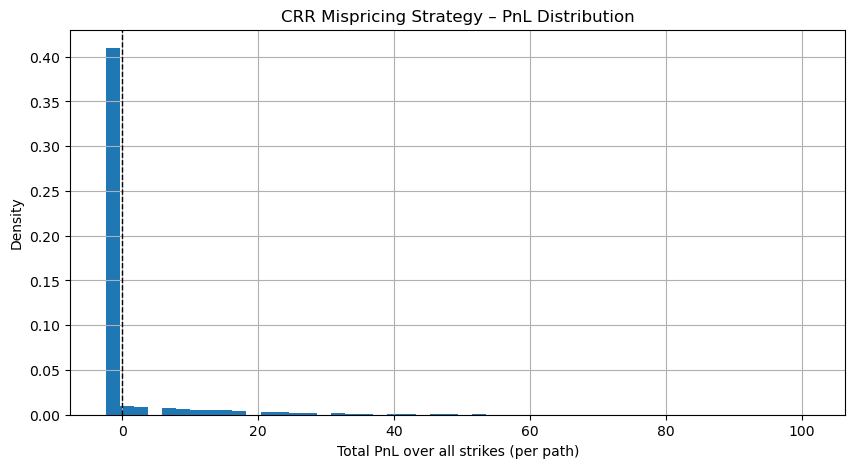

=== PnL summary ===
Mean PnL    : 0.1001
Std PnL     : 7.7187
5% quantile : -2.4621
Median      : -2.4621
95% quantile: 15.5255


In [21]:
results_crr = run_crr_mispricing_strategy(
    S0=100.0,
    T=1.0,
    r=0.02,
    sigma=0.2,
    N_market=20,      # coarse tree used by "market"
    N_model=500,      # fine tree used by "our model"
    K_min=80.0,
    K_max=120.0,
    n_strikes=11,
    mispricing_threshold=0.03,
    n_paths=50000,
    seed=123,
)

plot_crr_mispricing(results_crr)
plot_crr_pnl_distribution(results_crr)
